# Bayesian UQ-SINDy

In [1]:
from jax import config
config.update("jax_enable_x64", True)

import numpyro
numpyro.set_host_device_count(2)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp

import pysindy as ps

In [3]:
# set seed for reproducibility
np.random.seed(123)

### Lotka-Volterra Predator-Prey Model

In this example, we generate the data using the Lotka-Volterra equations, which is a simplified model of Predator-Prey interactions. They specify a system of Ordinary Differential Equations (ODEs):
\begin{align}
\frac{dP}{dt} &= a P - b P Q\\
\frac{dQ}{dt} &= c P Q - d Q
\end{align}
where $P$ is the concentration of prey, $Q$ is the concentration of predators, $a$ is the birth rate of prey, $b$ is the death rate of prey, $c$ is the birth rate of predators and $d$ is the death rate of predators.

For more details, see e.g. Rockwood L. L. and Witt J. W. (2015). *Introduction to population ecology*. Wiley Blackwell, Chichester, West Sussex, UK, 2nd edition

In [4]:
# set up a class that defines the Lotka-Volterra equations
class PredatorPreyModel:
    def __init__(self, a=1.0, b=0.3, c=0.2, d=1.0):
        # internalise the model parameters.
        self.a = a
        self.b = b
        self.c = c
        self.d = d

    def dydx(self, t, y):
        # Lotka-Volterra Model model, see e.g. https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations.}
        return np.array([self.a*y[0] - self.b*y[0]*y[1], self.c*y[0]*y[1] - self.d*y[1]])

    def solve(self, **kwargs):
        # solve the system of ODEs.
        return solve_ivp(self.dydx, **kwargs)

In [5]:
# set some hyperparameters.
t_span = [0, 30]
t_eval = np.linspace(*t_span, 50)
y0 = np.array([10,5])

# initialise the model and solve.
my_model = PredatorPreyModel()
sol = my_model.solve(t_span=t_span, y0=y0, t_eval=t_eval)

In [6]:
# the noise level.
noise = 0.1

# extract the timesteps and perturb the solution with noise.
t = sol.t
P = sol.y[0,:] + np.random.normal(scale=noise, size=sol.t.size)
Q = sol.y[1,:] + np.random.normal(scale=noise, size=sol.t.size)

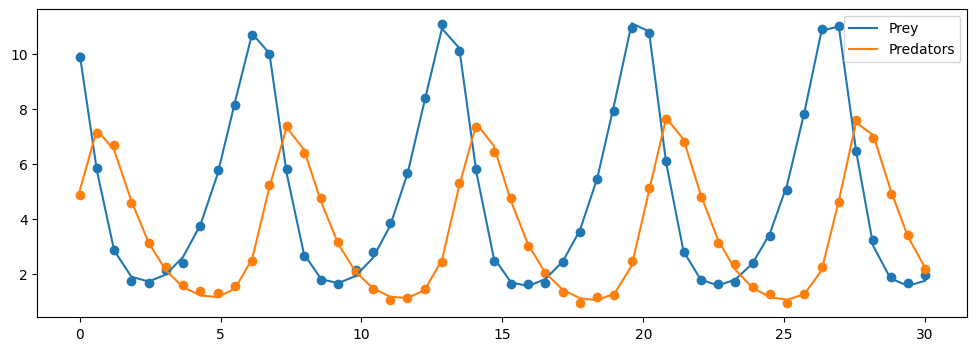

In [7]:
# plot the solution.
plt.figure(figsize=(12,4))
plt.plot(sol.t, sol.y[0,:], label = "Prey")
plt.scatter(t, P)
plt.plot(sol.t, sol.y[1,:], label="Predators")
plt.scatter(t, Q)
plt.legend()
plt.show()

### Bayesian UQ-SINDy

Here we recover the governing equations using UQ-SINDy. For more details on the theory of the method, see Hirsh, S. M., Barajas-Solano, D. A., & Kutz, J. N. (2021). *Sparsifying Priors for Bayesian Uncertainty Quantification in Model Discovery* (arXiv:2107.02107). arXiv. http://arxiv.org/abs/2107.02107

The underlying code used to find the posterior distribution of model parameters is `numpyro.infer.MCMC` using the `numpyro.infer.NUTS` kernel. Note that all keyword arguments passed to `pysindy.optimizers.SBR` are sent forward to the [MCMC sampler](https://num.pyro.ai/en/stable/mcmc.html).

In [8]:
# set sampler hyperparameters
sampling_seed = 123

if __name__ == "testing":
    num_warmup = 10
    num_samples = 100
    num_chains = 1
else:
    num_warmup = 100
    num_samples = 1000
    num_chains = 1

In [9]:
#import jax.numpy as jnp
#import json
#
#with open('posterior_mean.json') as f:
#    init = json.load(f)
#init = {key: jnp.array(value) for key, value in init.items()}

In [17]:
map_optimizer = ps.optimizers.STLSQ(alpha=10, normalize_columns=True)
feature_library = ps.feature_library.polynomial_library.PolynomialLibrary(include_interaction=True, include_bias=False)
sindy = ps.SINDy(map_optimizer, feature_library, feature_names=['P', 'Q'])
sindy.fit(np.c_[P, Q], t=t)

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(include_bias=False),
      feature_names=['P', 'Q'],
      optimizer=STLSQ(alpha=10, normalize_columns=True))

In [18]:
import jax.numpy as jnp
map = {"beta": jnp.array(sindy.coefficients())}

In [19]:
map

{'beta': Array([[ 0.        ,  1.37918447,  0.        , -0.04401486, -0.27912435],
        [-0.02442119, -0.8269197 ,  0.00752676,  0.16040094,  0.        ]],      dtype=float64)}

In [20]:
# initialise the Sparse bayesian Regression optimizer.
optimizer = ps.optimizers.SBR(normalize_columns=True,
                              num_warmup=num_warmup,
                              num_samples=num_samples,
                              mcmc_kwargs={"seed": sampling_seed,
                                           "num_chains": num_chains},
                              init=map,
                              )

# use the standard polynomial features.
feature_library = ps.feature_library.polynomial_library.PolynomialLibrary(include_interaction=True, include_bias=False)

# initialise SINDy and fit to the data.
sindy = ps.SINDy(optimizer, feature_library, feature_names=['P', 'Q'])
sindy.fit(np.c_[P, Q], t=t)

sample: 100%|█| 1100/1100 [00:24<00:00, 44.64it/s, 15 steps of size 8.77e-03. ac


SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(include_bias=False),
      feature_names=['P', 'Q'],
      optimizer=SBR(mcmc_kwargs={'num_chains': 1, 'seed': 123},
                    num_samples=1000, num_warmup=100))

In [21]:
# set up a new differential equation that uses the Bayesian SINDy predictions.
def surrogate_dydt(t, y):
    _y = y[np.newaxis,:]
    return sindy.predict(x=_y)

# solve using the Bayesian SINDy equations.
surrogate_sol = solve_ivp(surrogate_dydt, t_span=t_span, y0=y0, t_eval=t_eval)

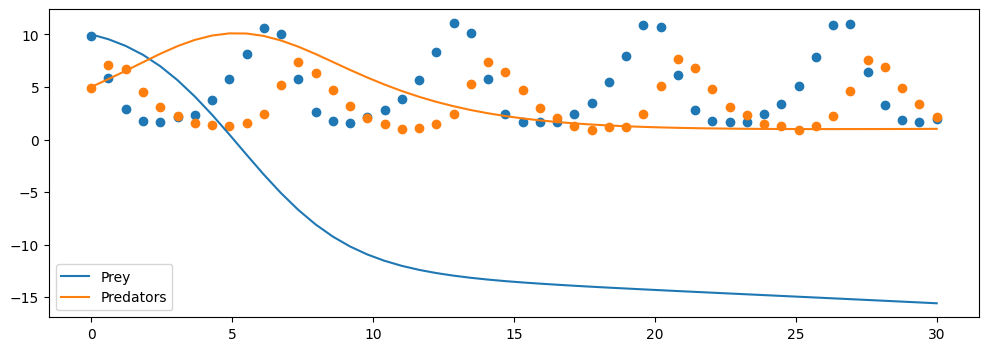

In [22]:
# plot the surrogate solution.
plt.figure(figsize=(12,4))

plt.plot(surrogate_sol.t, surrogate_sol.y[0,:], label = "Prey")
plt.scatter(t, P)

plt.plot(surrogate_sol.t, surrogate_sol.y[1,:], label="Predators")
plt.scatter(t, Q)

plt.legend()
plt.show()

### Get MCMC diagnostics

We can inspect the posterior samples in more detail using `arviz`. Note that this is not included as a dependency of `pysindy` and must be installed separately.

In [23]:
import jax.numpy as jnp

In [24]:
# import arviz.
import arviz as az

In [25]:
# convert the numpyro samples to an arviz.InferenceData object.
samples = az.from_numpyro(sindy.optimizer.mcmc_)

# have a look at the summray.
az.summary(samples)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"beta[0, 0]",0.424,0.060,0.330,0.452,0.035,0.030,2.0,11.0,NaN
"beta[0, 1]",0.460,0.037,0.412,0.490,0.004,0.004,31.0,13.0,NaN
"beta[0, 2]",0.064,0.058,-0.049,0.090,0.031,0.024,2.0,7.0,NaN
"beta[0, 3]",-0.058,0.094,-0.074,0.005,0.010,0.007,8.0,3.0,NaN
"beta[0, 4]",-5.745,0.097,-5.805,-5.738,0.008,0.006,3.0,29.0,NaN
"beta[1, 0]",0.472,0.068,0.460,0.482,0.017,0.012,2.0,2.0,NaN
"beta[1, 1]",-1.150,0.081,-1.161,-1.139,0.008,0.006,14.0,13.0,NaN
"beta[1, 2]",0.806,0.134,0.780,0.862,0.010,0.007,5.0,2.0,NaN
"beta[1, 3]",3.211,0.106,3.192,3.253,0.020,0.014,4.0,2.0,NaN
"beta[1, 4]",0.851,0.065,0.844,0.914,0.006,0.004,6.0,3.0,NaN


[]

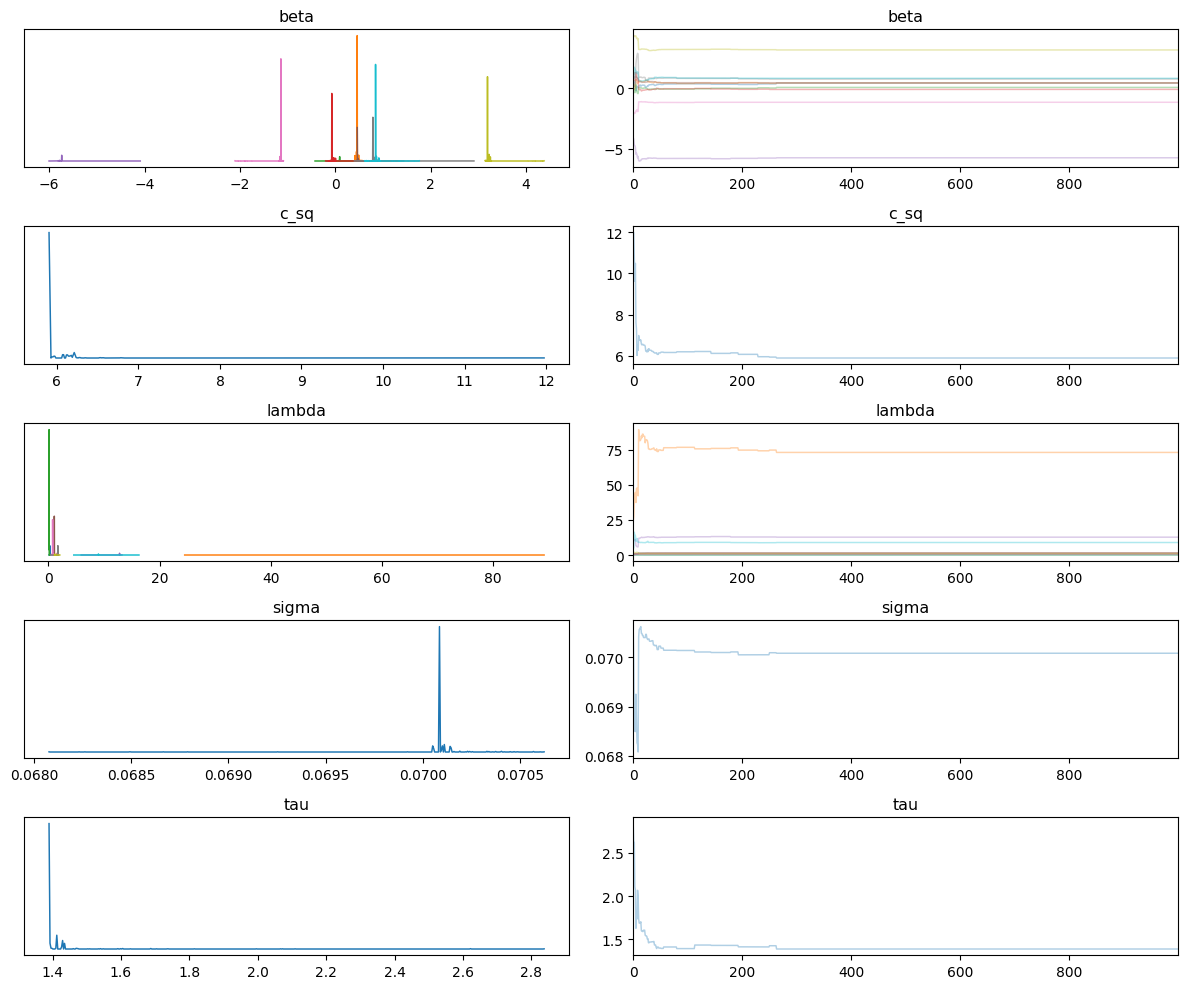

In [26]:
# plot the traces.
az.plot_trace(samples, divergences=False)
plt.tight_layout()
plt.plot()